# Experiments for the 2D Eiknonal equation in a square

This corresponds to the first numerical experiment in the paper

In [6]:
import torch.optim as optim
import matplotlib.pyplot as plt
import torch
from time import time as t

import sys
# setting path
sys.path.append('../')

from visualization.plots_cube import plot_2d_proj
from Hamiltonians.Eikonal_LxF import Eikonal_sq_LF_multiD


dim = 2

side_length = 6.

from PointSampling.Cube import data_gen_cube
domain = data_gen_cube(side_length, dim)

#Right-hand-side of the PDE
def f(X):    
    return 1

#Boundary condition
def g(X):    
    return 0

In [23]:
from Training.training import train
from error_test.cube_error import error_cube


training_params = {
    'numerical_scheme': Eikonal_sq_LF_multiD,

    'f': f,
    'g': g,
    'c': None,
    
    'beta': 0.,  ## parameter for the +u term
    'lambda': 1. #weight parameter for the boundary loss
    }

delta_list = [.75, .5, .3, .1, .01]
alpha_list = [2.5, 2., 1.5, 1., .5]
rounds = len(delta_list)

N_col_list = [30, 40, 80, 100, 1000]
N_b_list = [30]*rounds
num_iterations_list = [1000]*(rounds-1) + [1000]

../visualization/plots_cube.py:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(GridX.detach(), GridY.detach(), V.detach())


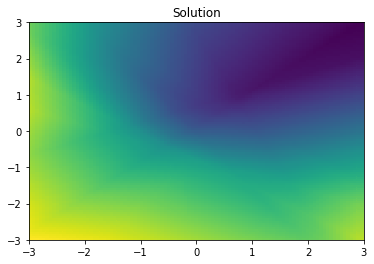

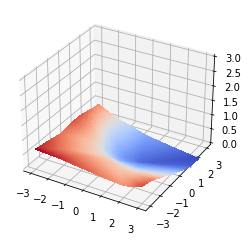

100%|██████████| 1000/1000 [00:01<00:00, 911.10it/s]


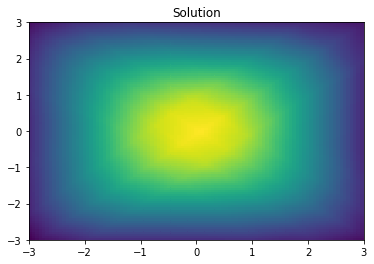

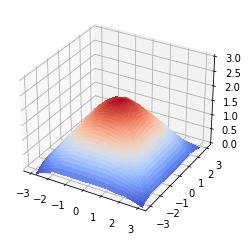

100%|██████████| 1000/1000 [00:01<00:00, 852.27it/s]


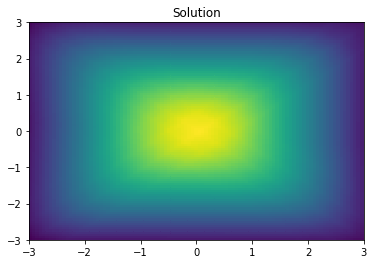

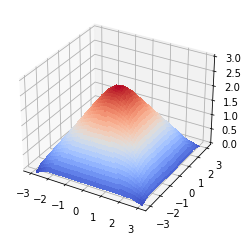

100%|██████████| 1000/1000 [00:01<00:00, 770.41it/s]


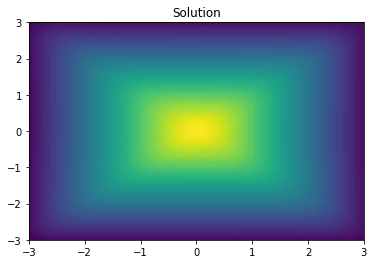

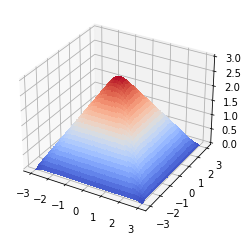

100%|██████████| 1000/1000 [00:01<00:00, 736.63it/s]


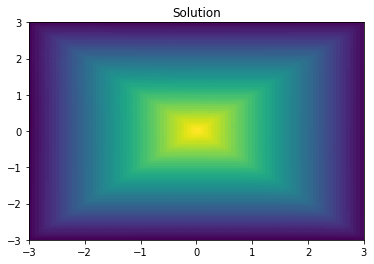

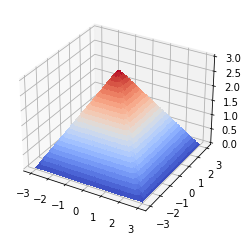

100%|██████████| 1000/1000 [00:01<00:00, 548.39it/s]


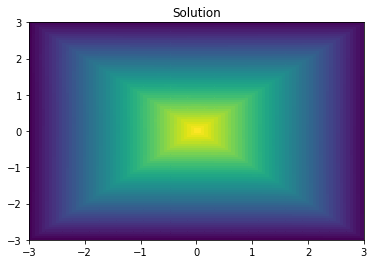

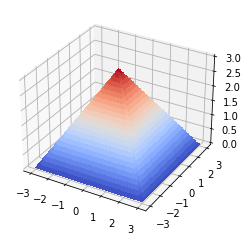

Mean square error: tensor(9.4942e-06)
L-infinity error: tensor(0.0094)
Run time: tensor(6.7581)


In [24]:
MSE_history = torch.zeros(rounds)
L_inf_error_history = torch.zeros(rounds)
run_time_history = torch.zeros(rounds)

# For reproducibility
torch.manual_seed(0)

# We define the NN
from NeuralNetworks.NNs import FCFF_2L
NN = FCFF_2L([dim,20])

training_params['optimizer'] = optim.SGD(NN.parameters(), lr = .02, momentum = .2)

X_axis = 0
Y_axis = 1

n_grid = 100
plot_2d_proj(X_axis, Y_axis, NN, n_grid, side_length)

for i in range(rounds):
    
    training_params['alpha'] = alpha_list[i]
    training_params['delta'] = delta_list[i]
    training_params['n_coloc_points'] = N_col_list[i]
    training_params['n_boundary_points'] = N_b_list[i]
    training_params['num_iterations'] = num_iterations_list[i]
    
    t0 = t()
    total_loss, PDE_loss, boundary_loss = train(NN, domain, training_params)
    t1 = t() - t0 
    
    
    MC_points = int(1e5) # Number of grid points for comparison with the ground truth
    MSE, L_inf = error_cube(NN, side_length, MC_points)
    
    MSE_history[i] = MSE
    L_inf_error_history[i] = L_inf
    run_time_history[i] = t1
    
    X_axis = 0
    Y_axis = 1

    n_grid = 100
    plot_2d_proj(X_axis, Y_axis, NN, n_grid, side_length)

print('Mean square error:', MSE)
print('L-infinity error:', L_inf)
print('Run time:', run_time_history.sum())

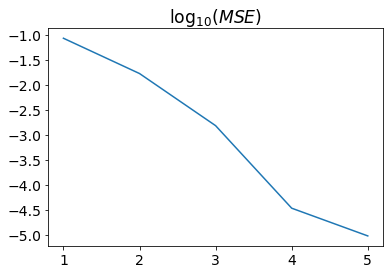

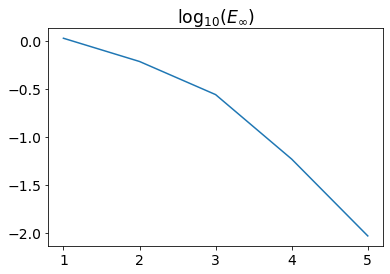

In [25]:
import numpy as np

from mpl_toolkits.axes_grid1 import host_subplot


x = np.arange(rounds) + 1
MSE_log10 =torch.log10(MSE_history)

ax = host_subplot(111)
ax.plot(x, MSE_log10)
ax.set_xticks(x)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('$\log_{10} (MSE)$', fontsize = 'xx-large')
plt.show()


L_inf_log10 = torch.log10(L_inf_error_history)
ax = host_subplot(111)
ax.plot(x, L_inf_log10)
ax.set_xticks(x)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('$\log_{10} (E_{\infty})$', fontsize = 'xx-large')
plt.show()